clean data

In [1]:
import numpy as np
import pandas as pd

def NASDAQ_csv_input(file_name, file_path):
    """
    Converts NASDAQ stock csv files to pd.dataframe with dtypes 
    [Datetime, np.float32, np.float32, np.float32, np.float32, np.int32] 
    in ascending order.
    Parameters:
    file_name: string name of full file name
    file_path: string name of full path to file
    Returns:
    pd.dataframe
    """
    # Import File
    ohlcv_data = pd.read_csv(f'{file_path}/{file_name}').iloc[::-1].reset_index(drop=True)

    # Updating Column names and order
    column_names_mapping = {'Date':'date',
                            'Close/Last':'close',
                            'Volume':'volume',
                            'Open':'open',
                            'High':'high',
                            'Low':'low'}
    desired_order = ['date','open','high','low','close','volume']
    ohlcv_data = ohlcv_data.rename(columns=column_names_mapping)[desired_order]

    # Converting to Date String to datetime datatype
    ohlcv_data['date'] = pd.to_datetime(ohlcv_data['date'], format='%m/%d/%Y')

    # Converting currency columns to float32 datatype
    columns_with_dollars = [col for col in column_names_mapping.values() if col not in ['date','volume']]
    for col in columns_with_dollars:
        ohlcv_data[col] = ohlcv_data[col].str.replace('$', '').astype(np.float32)

    # Converting 'volume' column to int32 datatype
    ohlcv_data['volume'] = ohlcv_data['volume'].astype(np.int32)

    return ohlcv_data


DQN Agent data load

In [2]:
import sys
pwd = r"C:\Users\augus\OneDrive\Desktop\rl_stock_agents"
sys.path.append(pwd)


#stock_list =["amzn_daily.csv"] # "appl_daily.csv","tsla_daily.csv","f_daily.csv","pfe_daily.csv","coke_daily.csv","brk_daily.csv","nee_daily.csv","jnj_daily.csv","pg_daily.csv"]

file_name = 'amzn_daily.csv'#,'APPL','TSLA','F','PFE','COKE','BRK','NEE','JNJ','PG']

import_path = r"C:\Users\augus\OneDrive\Desktop\rl_stock_agents\input_data"

# training_range = ohlcv_data[0,2000]
# test_range = ohlcv_data[2000,2516]

# Import File
ohlcv_data = NASDAQ_csv_input(file_name,import_path)
display(ohlcv_data)

C:\Users\augus\AppData\Local\Temp\ipykernel_35288\3563800451.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ohlcv_data[col] = ohlcv_data[col].str.replace('$', '').astype(np.float32)


,date,open,high,low,close,volume
0,2013-12-30,19.970501,19.996000,19.622499,19.668501,49706920
1,2013-12-31,19.729000,19.941500,19.690001,19.939501,39921780
2,2014-01-02,19.940001,19.968000,19.701000,19.898500,42756140
3,2014-01-03,19.914499,20.135500,19.811001,19.822001,44201280
4,2014-01-06,19.792500,19.850000,19.421000,19.681499,63411740
...,...,...,...,...,...,...
2513,2023-12-22,153.770004,154.350006,152.710007,153.419998,29514090
2514,2023-12-26,153.559998,153.975006,153.029999,153.410004,25067220
2515,2023-12-27,153.559998,154.779999,153.119995,153.339996,31434730
2516,2023-12-28,153.720001,154.080002,152.949997,153.380005,27057000


Environment

In [3]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

class ContinuousOHLCVEnv(gym.Env):
    def __init__(self, ohlcv_data, initial_cash=1000):
        self.ohlcv_raw_data = ohlcv_data
        self.initial_cash = initial_cash
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,))
        self.max_idx = ohlcv_data.shape[0] - 1
        self.reset()

    def reset(self):
        self.current_step = 0
        self.cash_in_hand = self.initial_cash
        self.stock_holding = 0
        self.step_info = []  # Initialize an empty list to store step information
        self.stock_price = self.ohlcv_raw_data[self.current_step][3]  # Assuming closing price for stock price
        self.total_portfolio_value = self.cash_in_hand + (self.stock_holding * self.stock_price)
        self.available_actions = (0, 1)  # Can hold or buy initially
        return self.get_observation()
    
    def step(self, action):
        assert self.action_space.contains(action), f'Action {action} not in action space'

        prev_valuation = self.total_portfolio_value

        if action == 1:  # Buy
            self._buy()
        elif action == 2:  # Sell
            self._sell()

        # Update portfolio value
        self.total_portfolio_value = self.cash_in_hand + (self.stock_holding * self.stock_price)
        reward = self.total_portfolio_value - prev_valuation
        done = self.current_step >= (len(self.ohlcv_raw_data) - 1)

        step_data = {
            'Step': self.current_step,
            'Portfolio Value': np.round(self.total_portfolio_value, 2),
            'Cash': np.round(self.cash_in_hand, 2),
            'Stock Value': np.round(self.stock_price * self.stock_holding, 2), 
            'Stock Holdings': np.round(self.stock_holding, 0),
            'Stock Price': np.round(self.stock_price, 2),
            'Available Actions': self.available_actions,
            'Action': action
        }
        self.step_info.append(step_data)

        if not done:
            self.current_step += 1
            self.stock_price = self.ohlcv_raw_data[self.current_step][3]

        # Update available actions
        if self.stock_holding > 0:
            self.available_actions = (0, 2)  # Can hold or sell
        else:
            self.available_actions = (0, 1)  # Can hold or buy

        next_observation = self.get_observation()
        info = {'available_actions': self.available_actions}
        return next_observation, reward, done, info
    
    def _buy(self):
        self.num_stocks_buy = np.floor(self.cash_in_hand/self.stock_price) # Buy 
        #Maximum allowed (Current Method)
        self.cash_in_hand -= self.num_stocks_buy * self.stock_price
        self.stock_holding = self.num_stocks_buy
        self.num_stocks_buy = 0
        self.available_actions = (-1,0)
        return
    
    def _sell(self):
        self.num_stocks_sell = self.stock_holding # Sell all stocks (Current Mehtod)
        self.cash_in_hand += self.num_stocks_sell * self.stock_price  # No commission
        #fee can be added later
        self.stock_holding -= self.num_stocks_sell
        self.num_stocks_sell = 0
        self.available_actions = (0,1)
        return
 
    def get_observation(self):
        return(tuple(self.ohlcv_raw_data[self.current_step]))

    def get_step_data(self):
        return pd.DataFrame(self.step_info)  # Generate a DataFrame from stored 
    #step information

DQN Agent

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
import time
import random

class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_dqn(env):
    print("\t".join(["epoch", "epsilon", "total_step", "log_reward", "log_loss", "elapsed_time", "total financial return"]))

    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    hidden_size = 100

    Q = QNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
    Q_ast = copy.deepcopy(Q)
    optimizer = optim.Adam(Q.parameters())

    # Hyperparameters
    epoch_num = 50
    step_max = len(env.ohlcv_raw_data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 50
    update_q_freq = 90
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    return_dqn = 0

    start = time.time()
    for epoch in range(epoch_num):
        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:
            # Select action
            if np.random.rand() > epsilon:
                pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32)).unsqueeze(0)).detach()
                pact = pact.max(1)[1].item()
            else:
                pact = env.action_space.sample()

            # Act
            obs, reward, done, _ = env.step(pact)

            # Add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # Train or update Q
            if len(memory) == memory_size and total_step % train_freq == 0:
                mini_batch = random.sample(memory, batch_size)
                b_pobs = torch.from_numpy(np.array([item[0] for item in mini_batch], dtype=np.float32))
                b_pact = torch.from_numpy(np.array([item[1] for item in mini_batch], dtype=np.int64))
                b_reward = torch.from_numpy(np.array([item[2] for item in mini_batch], dtype=np.float32))
                b_obs = torch.from_numpy(np.array([item[3] for item in mini_batch], dtype=np.float32))
                b_done = torch.from_numpy(np.array([item[4] for item in mini_batch], dtype=bool))

                q = Q(b_pobs)
                maxq = Q_ast(b_obs).detach().max(1)[0]
                target = q.clone()
                for i in range(batch_size):
                    target[i, b_pact[i]] = b_reward[i] + gamma * maxq[i] * (not b_done[i])

                # Loss and optimize
                optimizer.zero_grad()
                loss = nn.functional.mse_loss(q, target)
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

            # Update Q_ast
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)

            # Epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # Next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        # Logging
        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):]) / show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):]) / show_log_freq
            elapsed_time = time.time() - start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()

    final_return = sum(total_rewards)
    print(f"final return : {final_return}")

    return Q, total_losses, total_rewards, final_return

train

In [5]:
env = ContinuousOHLCVEnv(ohlcv_data[["open","high","low",'close',"volume"]].to_numpy())  # You need to provide the ohlcv_data
Q, losses, rewards, final_return = train_dqn(env)


epoch	epsilon	total_step	log_reward	log_loss	elapsed_time	total financial return


5	0.0999999999999992	12585	-995.1061424255371	12085161864197.98	1.690561056137085
10	0.0999999999999992	25170	-986.9940605163574	32495629.699163735	1.7648959159851074
15	0.0999999999999992	37755	-992.1508975982666	486863.52449150087	1.8206310272216797
20	0.0999999999999992	50340	-998.6535360336304	6526088990789.502	1.809800624847412
25	0.0999999999999992	62925	-995.0074272155762	900329507880.8	1.7515809535980225
30	0.0999999999999992	75510	-997.7399017333985	6548045583.876562	1.7330358028411865
35	0.0999999999999992	88095	-998.0399299621582	293168581.16748047	1.7374160289764404
40	0.0999999999999992	100680	-994.0017185211182	9688062478.347656	1.7746553421020508
45	0.0999999999999992	113265	-996.5771482467651	6417461383861.98	1.7385191917419434
50	0.0999999999999992	125850	-995.776821899414	8964101.225795174	1.807729721069336
final return : -49750.23792076111


Agent performance

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def agent_stock_performance(stock_price_ts: np.ndarray, trade_ts: np.ndarray, stock_name: str, agent_name: str):
    buy_price_idx = np.where(trade_ts == 1)[0]
    sell_price_idx = np.where(trade_ts == 2)[0]

    # Ensure the lengths of buy and sell indices are equal for comparison
    min_length = min(len(buy_price_idx), len(sell_price_idx))
    buy_price_idx = buy_price_idx[:min_length]
    sell_price_idx = sell_price_idx[:min_length]

    # Proceed with the calculations
    buy_price = stock_price_ts[buy_price_idx]
    sell_price = stock_price_ts[sell_price_idx]
    fig, ax = plt.subplots()
    ax.plot(stock_price_ts, color='grey')
    ax.scatter(buy_price_idx, buy_price, color='g', marker="^")
    ax.scatter(sell_price_idx, sell_price, color='r', marker="v")

    trade_wins = np.sum(stock_price_ts[buy_price_idx] < stock_price_ts[sell_price_idx])
    trade_loss = np.sum(stock_price_ts[buy_price_idx] > stock_price_ts[sell_price_idx])
    trade_total = min_length

    # Calculate Rate of Return (ROR) per trade
    ror_per_trade = stock_price_ts[sell_price_idx] / stock_price_ts[buy_price_idx]
    trade_return = np.prod(ror_per_trade)
    win_percentage = (trade_wins / trade_total) * 100 if trade_total > 0 else 0

    # Highlighting Buy-Sell periods
    for start, end in zip(buy_price_idx, sell_price_idx):
        color = 'grey' if stock_price_ts[start] == stock_price_ts[end] else ('g' if stock_price_ts[start] < stock_price_ts[end] else 'r')
        ax.axvspan(start, end, color=color, alpha=0.15)

    plt.title(f'{agent_name} Agent: {stock_name} Trade Performance')
    plt.ylabel(f'{stock_name} Price')
    plt.xlabel('Time Step')

    plotbox_x = 10
    plotbox_y = np.median(stock_price_ts) - (min(stock_price_ts) / 4.75)

    textbox_content = (f"Trades: {trade_total:>5}\n"
                       f"Wins: {trade_wins:>8}\n"
                       f"Loss: {trade_loss:>8}\n"
                       f"Win %: {win_percentage:.2f}\n"
                       f"ROR: {trade_return:.3f}")

    ax.text(plotbox_x, plotbox_y, textbox_content, bbox=dict(facecolor='yellow', alpha=0.5), 
            horizontalalignment='left', verticalalignment='bottom', fontsize=8)

    plt.show()

    results = {"n_trades": trade_total, 
               "n_wins": trade_wins, 
               "n_losses": trade_loss, 
               "win_percentage": win_percentage, 
               "ror": trade_return}

    return results

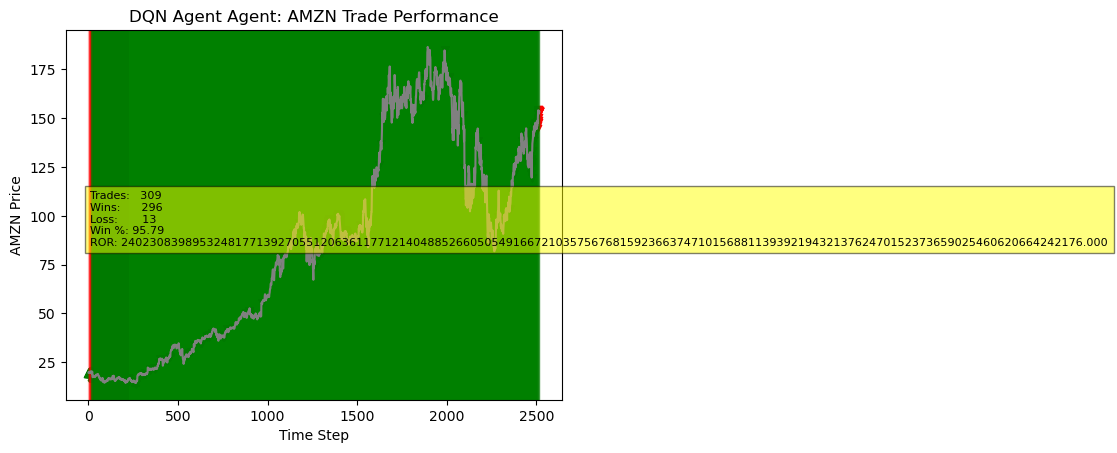

In [9]:
# Assuming `env` is your trading environment instance after DQN run
step_data = env.get_step_data()  # Extract the DataFrame from step_info

# Extract actions and stock prices
actions_taken = step_data['Action'].to_numpy()
stock_prices = step_data['Stock Price'].to_numpy()

# Analyze performance
performance_results = agent_stock_performance(
    stock_price_ts=stock_prices,
    trade_ts=actions_taken,
    stock_name="AMZN",
    agent_name="DQN Agent"
)

In [ ]:




###########################################################

#DQN Agent
import sys
pwd = "P:/dsv/DAMII/Practical Project/rl_stock_agents"
sys.path.append(pwd)

import cleandata
import numpy as np
from stockenv import ContinuousOHLCVEnv
import matplotlib.pyplot as plt
from agentperform import agent_stock_performance
from agents import DQNAgent
import logging



stock_list =["amzn_daily.csv"]#, "appl_daily.csv","tsla_daily.csv","f_daily.csv","pfe_daily.csv",
             #"coke_daily.csv","brk_daily.csv","nee_daily.csv","jnj_daily.csv","pg_daily.csv"]

stock_name_list = ['AMZN']#,'APPL','TSLA','F','PFE','COKE','BRK','NEE','JNJ','PG']

import_path = "P:/dsv/DAMII/Practical Project/rl_stock_agents/input_data"


# Instantiate the environment

results =[]

for file_name, stock_name in zip(stock_list,stock_name_list):
    # Import File
    
    df_ohlcv = cleandata.NASDAQ_csv_input(file_name,import_path)


    env = ContinuousOHLCVEnv(df_ohlcv[["open","high","low",'close',"volume"]].iloc[:2000].to_numpy())


    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    available_actions = env.available_actions

    # Create a DQN agent
    agent = DQNAgent(state_size, action_size,available_actions)

    batch_size = 32
    EPISODES = 50  # Number of episodes for training

    for e in range(EPISODES):
        logging.info(e)
        env.reset()
        state = env.get_observation()
        state = np.reshape(state, [1, state_size])
        print(available_actions)
        for time in range(500):  # Adjust the number of time steps per episode
            action, action_type = agent.act(state)
            next_state, reward, new_available_actions, done = env.step(action)
            logging.info(action_type)
            logging.info(env.step_info[-1])
            agent.available_actions = new_available_actions
            reward = reward if not done else -10  # Modify the reward as needed
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print(f"episode: {e}/{EPISODES}, score: {time}, epsilon: {agent.epsilon:.2}")
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

+++++++++++++++++++++++++++++++++


In [ ]:
Stock performance plots
import matplotlib.pyplot as plt
import numpy as np

def agent_stock_performance(stock_price_ts: np.ndarray, trade_ts: np.ndarray,stock_name: str, agent_name:str):
    # ---------------------------------------------------------------------------------------------
    # Converts NASDAQ stock csv files from https://www.nasdaq.com/market-activity/quotes/historical
    # to pd.dataframe[date, open, high, low, close, volume] 
    # with dtypes[Datetime,np.float32, np.float32, np.float32, np.float32, np.float32, np.int)
    # in ascentding order
    #----------------------------------------------------------------------------------------------
    ## Parameters:
    #-----------------------------------------------------------------------------------------------
    #   stock_price_ts: (np.narray) 
    #       1-D array with stock's price at each timestep 
    #   trade_ts: (np.narray)
    #       1-D array with agent's action at each time step. Action defined as [-1,0,1] as
    #       [Sell, Hold, Buy] respectively.  
    #   stock_name: (str)
    #       Name of stock, for labeling of plot
    #   agent_name: (str)
    #       Name of agent, for labeling of plot
    #----------------------------------------------------------------------------------------------
    # Returns:
    #----------------------------------------------------------------------------------------------
    #   dict: dict.keys=["n_trades", "n_wins", "n_losses", "win_percentage", "ror"]
    #       dictionary with agent's trade performance:
    #           - number of trades
    #           - number of winning trades
    #           - number losing trades
    #           - trade win percentage
    #           - rate of return (product of all conducted trade returns)
    # ----------------------------------------------------------------------------------------------  

        
    # Finding index and stock price of Buy Action
    buy_price_idx = np.where(trade_ts == 'B')[0]
    buy_price_idx = buy_price_idx.astype(int)
    buy_price = stock_price_ts[buy_price_idx]

    # Finding index and stock price of Sell Action
    sell_price_idx = np.where(trade_ts == 'S')[0]
    sell_price_idx = sell_price_idx.astype(int)
    sell_price = stock_price_ts[sell_price_idx]

    # Ploting Stock Price and locations of Buy and Sell Actions
    fig, ax = plt.subplots()
    ax.plot(stock_price_ts, color='grey')
    ax.scatter(buy_price_idx,buy_price,color='g',marker="^")
    ax.scatter(sell_price_idx,sell_price,color='r',marker="v")

    # Calculating Win, Loss, Total Trades
    trade_wins = np.sum(stock_price_ts[buy_price_idx] < stock_price_ts[sell_price_idx])
    trade_loss = np.sum(stock_price_ts[buy_price_idx] > stock_price_ts[sell_price_idx])
    trade_total = int((len(buy_price_idx) + len(sell_price_idx))/2) #Function assumes trade_ts has proper buy-sell patterns 
    trade_return = np.prod(stock_price_ts[sell_price_idx] / stock_price_ts[buy_price_idx])
    win_precentage = trade_wins/trade_total*100
    
    ror_per_tradeframe = []
    assert len(buy_price_idx) == len(sell_price_idx), "Arrays should have the same length"
    buy_sell_len = len(buy_price_idx)
    for idx in range(buy_sell_len):
        sell_idx = sell_price_idx[idx]
        buy_idx = buy_price_idx[idx]
        assert buy_idx < sell_idx, "Buy time index should occur before sell time index"
        if idx > 0:
            last_buy_idx = buy_price_idx[idx - 1]
            last_sell_idx = sell_price_idx[idx - 1]
            assert sell_idx > last_buy_idx, "Sell time index should occur before last buy time index"
            assert buy_idx > last_sell_idx, "Buy time index should occur after last buy time index"        
        ror = stock_price_ts[sell_idx] / stock_price_ts[buy_idx]
        ror_per_tradeframe.append(ror)

    trade_return = np.prod(ror_per_tradeframe)
    
    hl_start = np.where(trade_ts == 'B')[0]
    hl_end = np.where(trade_ts == 'S')[0]

    for start, end in zip(hl_start, hl_end):
        color = 'grey' if stock_price_ts[start] == stock_price_ts[end] else ('g' if stock_price_ts[start] < stock_price_ts[end] else 'r')
        plt.axvspan(start, end, color=color, alpha=0.15)

    plt.title(f'{agent_name} Agent: {stock_name} Trade Performance')
    plt.ylabel(f'{stock_name} Price')
    plt.xlabel('Time Step')
    
    plotbox_x = 10
    plotbox_y = np.median(stock_price_ts) - (min(stock_price_ts)/4.75) 
        
    texbox_content = (f"Trades:{trade_total:>5}\n"
        f"Wins:{trade_wins:>8}\n"
        f"Loss: {trade_loss:>8}\n"
        f"Win %: {win_precentage:.2f}\n"
        f"ROR: {trade_return:.3f}"
    )
    ax.text(plotbox_x,
            plotbox_y,
            texbox_content, 
            bbox=dict(facecolor='yellow', alpha=0.5),
            horizontalalignment='left',
            verticalalignment='bottom',
            fontsize=8)      
    plt.show()
    
    results = {"n_trades": trade_total, 
               "n_wins": trade_wins, 
               "n_losses": trade_loss, 
               "win_percentage":win_precentage, 
               "ror":trade_return}

    return results
